In [4]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
import matplotlib as mpl
import sys


from nbodykit.lab import *

In [148]:
def measure_autopk(array,L):
    mesh = ArrayMesh(array,BoxSize=L)
    r = FFTPower(mesh, mode='1d')
    return r.power

In [153]:
def noise(nc):
    # Build a unit-distribution of complex numbers with random phase
    a = np.random.normal(loc=0, scale=1, size=(nc,nc,nc))
    b = np.random.normal(loc=0, scale=1, size=(nc,nc,nc))
    return a + 1j * b

In [178]:
L=1000
nc=128
wn = noise(nc)
a = measure_autopk(wn,L)

/home/metin/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[]

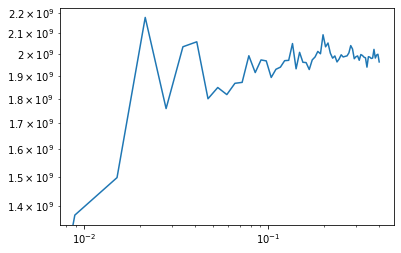

In [179]:
plt.plot(a['k'],a['power'])
plt.loglog()

In [180]:
k,p = np.loadtxt('Pk.input_zinit_normalized_at_z0.DAT',unpack=True)

In [181]:

"""Create k^2 in box (nc x nc x nc)"""
def k_box(nc,L):
    kfac = 2.*np.pi/L
    k= np.fft.fftfreq(nc,d=1./nc/kfac) #d controls spacing
    a = np.transpose(np.indices((nc,nc,nc)).T, (2, 1, 0, 3)) #1 grid cell 3 coordinates
    k2=(k[a]**2).sum(axis=-1) # each grid cell is sum of squares of coordinates
    return (np.sqrt(k2))

In [182]:
kbox = k_box(nc,L)

In [183]:
Pk_box = np.interp(kbox,k,p)

In [184]:
a = wn *np.sqrt(Pk_box)
               
aa = np.fft.ifftn(a).real

In [187]:
b = measure_autopk(aa,L)

/home/metin/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[]

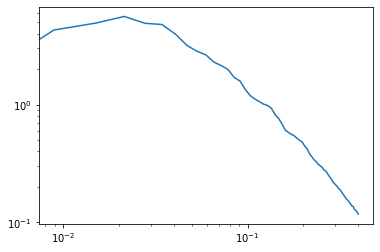

In [188]:
plt.plot(b['k'],b['power'])
plt.loglog()